# Special care should be taken with missing data on this problem.

Missing data shall never be filled in the target variable, or the results evaluation would be corrupted. That is a risk on this problem, if things are done without care, because the target variable and the features are the same, only time-shifted.

First forward and then backwards fill is the best way to try to keep causality as much as possible.

Some filtering of symbols that have a lot of missing data could help, or the predictor may find itself full of constant data.

Filling missing data and dropping "bad samples" can be done in two or three levels: In the total data level, in the training time level, or in the base samples level. The differences are probably small for the filling part, but may be significant when dropping samples. 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from utils import preprocessing as pp

In [3]:
data_df = pd.read_pickle('../../data/data_train_val_df.pkl')

In [4]:
print(data_df.shape)
data_df.head()

(5520, 2415)


feature     Close                                                 ... Volume  \
              SPY    MMM   ABT ABBV ACN ATVI AYI  ADBE    AMD AAP ...   WYNN   
date                                                              ...          
1993-01-29  43.94  24.50  6.88  NaN NaN  NaN NaN  2.59  18.75 NaN ...    NaN   
1993-02-01  44.25  24.69  6.88  NaN NaN  NaN NaN  2.72  19.12 NaN ...    NaN   
1993-02-02  44.34  24.72  6.53  NaN NaN  NaN NaN  2.84  20.25 NaN ...    NaN   
1993-02-03  44.81  25.19  6.91  NaN NaN  NaN NaN  2.70  20.50 NaN ...    NaN   
1993-02-04  45.00  26.06  6.84  NaN NaN  NaN NaN  2.73  20.12 NaN ...    NaN   

feature                                                                    
                 XEL        XRX       XLNX XYL YHOO YUM ZBH      ZION ZTS  
date                                                                       
1993-01-29   87800.0  7633602.0  1745196.0 NaN  NaN NaN NaN   33600.0 NaN  
1993-02-01   72400.0  3001200.0  3574800.0 NaN  NaN NaN NaN   32000.0 NaN  
1993-02-02  242200.0  1388598.0  2652396.0 NaN  NaN NaN NaN  251600.0 NaN  
1993-02-03  272200.0  1228200.0  5040396.0 NaN  NaN NaN NaN  254800.0 NaN  
1993-02-04  162800.0  1675602.0  7033200.0 NaN  NaN NaN NaN  317200.0 NaN  

[5 rows x 2415 columns]

In [5]:
data_df.columns.nlevels

2

## Let's first filter at the symbol level

In [6]:
data_df['Close'].shape

(5520, 483)

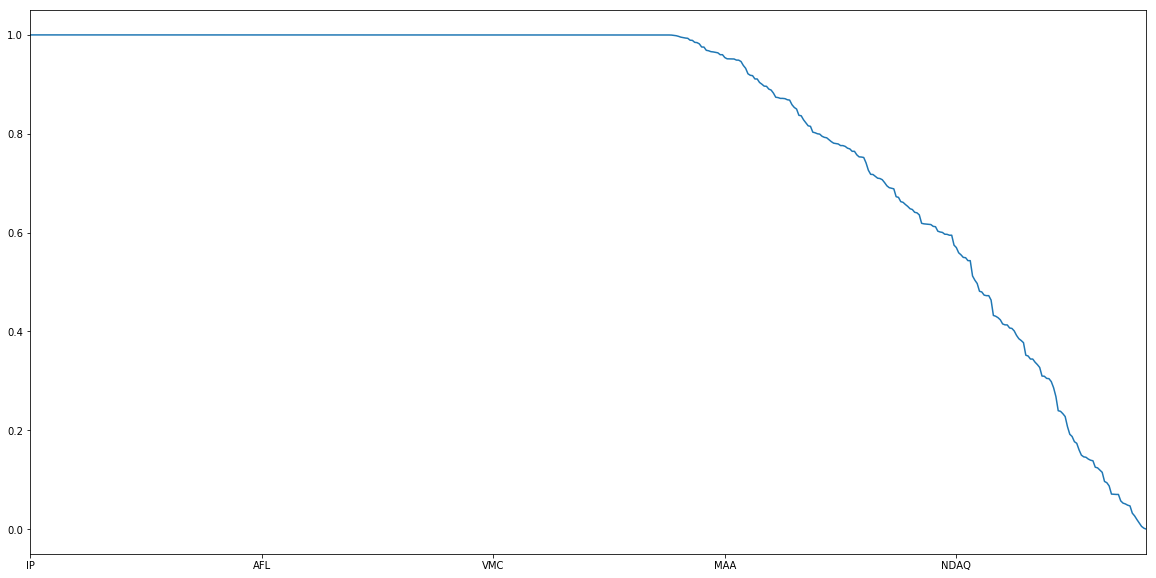

In [7]:
good_ratios = 1.0 - (data_df['Close'].isnull().sum()/ data_df['Close'].shape[0])
good_ratios.sort_values(ascending=False).plot()

In [8]:
filtered_data_df = pp.drop_irrelevant_symbols(data_df['Close'], good_data_ratio=0.99)

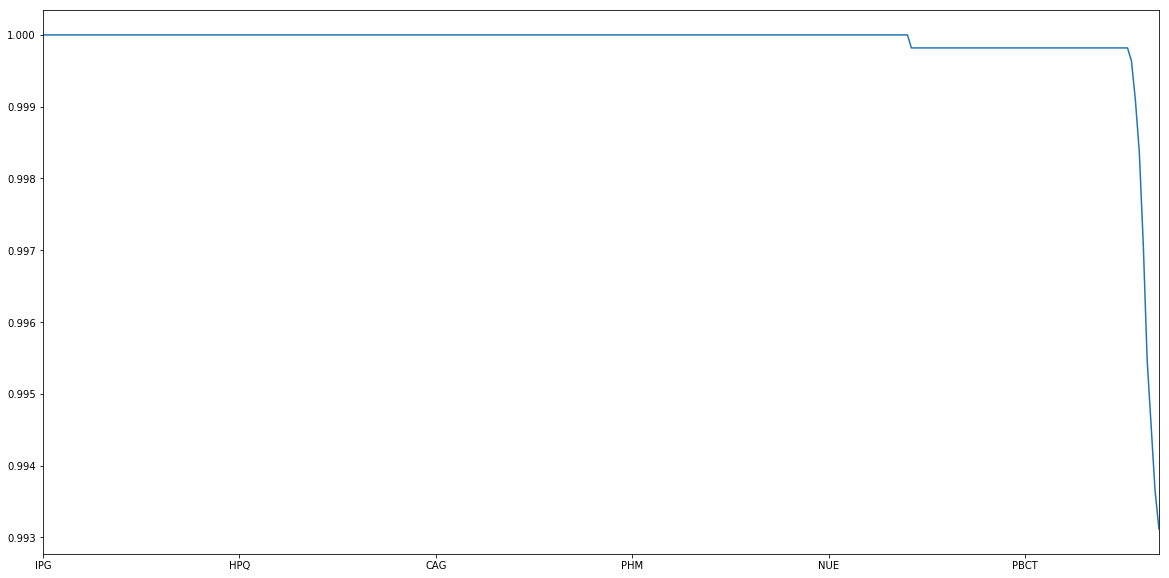

In [9]:
good_ratios = 1.0 - (filtered_data_df.isnull().sum()/ filtered_data_df.shape[0])
good_ratios.sort_values(ascending=False).plot()

In [10]:
filtered_data_df.shape

(5520, 285)

In [11]:
filtered_data_df.head()

,SPY,MMM,ABT,ADBE,AMD,AES,AET,AFL,APD,ALK,...,HCN,WDC,WY,WHR,WFM,WMB,XEL,XRX,XLNX,ZION
date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,43.94,24.50,6.88,2.59,18.75,4.41,6.42,4.49,21.94,4.19,...,22.50,4.50,41.50,46.12,1.81,6.88,22.00,14.28,2.50,10.94
1993-02-01,44.25,24.69,6.88,2.72,19.12,4.53,6.64,4.52,22.38,4.19,...,23.00,4.50,42.00,46.50,1.78,7.00,22.19,14.09,2.62,11.06
1993-02-02,44.34,24.72,6.53,2.84,20.25,4.53,6.62,4.57,22.31,4.16,...,22.75,4.62,42.12,46.50,1.78,6.98,22.06,14.09,2.64,11.12
1993-02-03,44.81,25.19,6.91,2.70,20.50,4.49,6.50,4.65,22.69,4.22,...,23.25,4.69,42.00,47.12,1.81,6.84,22.38,14.03,2.68,11.25
1993-02-04,45.00,26.06,6.84,2.73,20.12,4.49,6.73,4.84,23.19,4.38,...,23.00,4.56,42.62,48.38,1.84,6.90,22.81,14.15,2.67,11.69


In [12]:
filtered_data_df.isnull().sum().sort_values(ascending=False)

CB       38
MCHP     35
INTU     30
HUM      25
MS       16
GT        9
CHK       5
VRTX      2
ZION      1
PDCO      1
PAYX      1
PBCT      1
CMCSA     1
CSCO      1
CTAS      1
CINF      1
QCOM      1
COST      1
CERN      1
REGN      1
CELG      1
ROST      1
CA        1
SWKS      1
BIIB      1
BBBY      1
PCAR      1
XRAY      1
CSX       1
NTRS      1
         ..
MMC       0
MAS       0
PPG       0
PNC       0
PNW       0
PCG       0
PFE       0
PKI       0
PEP       0
PH        0
ORCL      0
OKE       0
OMC       0
OXY       0
NUE       0
NOC       0
NSC       0
JWN       0
NI        0
NKE       0
NEM       0
MUR       0
MSI       0
MOS       0
TAP       0
MHK       0
MRK       0
MCD       0
MKC       0
SPY       0
Length: 285, dtype: int64

### Let's try to filter the whole dataset using only the 'Close' values

In [13]:
good_data_ratio = 0.99
FEATURE_OF_INTEREST = 'Close'

filtered_data_df = data_df[FEATURE_OF_INTEREST].dropna(thresh=math.ceil(good_data_ratio*data_df[FEATURE_OF_INTEREST].shape[0]), axis=1)

In [14]:
filtered_data_df.head()

,SPY,MMM,ABT,ADBE,AMD,AES,AET,AFL,APD,ALK,...,HCN,WDC,WY,WHR,WFM,WMB,XEL,XRX,XLNX,ZION
date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,43.94,24.50,6.88,2.59,18.75,4.41,6.42,4.49,21.94,4.19,...,22.50,4.50,41.50,46.12,1.81,6.88,22.00,14.28,2.50,10.94
1993-02-01,44.25,24.69,6.88,2.72,19.12,4.53,6.64,4.52,22.38,4.19,...,23.00,4.50,42.00,46.50,1.78,7.00,22.19,14.09,2.62,11.06
1993-02-02,44.34,24.72,6.53,2.84,20.25,4.53,6.62,4.57,22.31,4.16,...,22.75,4.62,42.12,46.50,1.78,6.98,22.06,14.09,2.64,11.12
1993-02-03,44.81,25.19,6.91,2.70,20.50,4.49,6.50,4.65,22.69,4.22,...,23.25,4.69,42.00,47.12,1.81,6.84,22.38,14.03,2.68,11.25
1993-02-04,45.00,26.06,6.84,2.73,20.12,4.49,6.73,4.84,23.19,4.38,...,23.00,4.56,42.62,48.38,1.84,6.90,22.81,14.15,2.67,11.69


In [15]:
filtered_data_df.columns

Index(['SPY', 'MMM', 'ABT', 'ADBE', 'AMD', 'AES', 'AET', 'AFL', 'APD', 'ALK',
       ...
       'HCN', 'WDC', 'WY', 'WHR', 'WFM', 'WMB', 'XEL', 'XRX', 'XLNX', 'ZION'],
      dtype='object', length=285)

In [16]:
fdata_df = data_df.loc[:,(slice(None),filtered_data_df.columns.tolist())]

In [17]:
new_cols = fdata_df.columns.get_level_values(1)

In [18]:
np.setdiff1d(new_cols, filtered_data_df.columns)

array([], dtype=object)

In [19]:
np.setdiff1d(filtered_data_df.columns, new_cols)

array([], dtype=object)

In [20]:
np.intersect1d(filtered_data_df.columns, new_cols).shape

(285,)

In [21]:
filtered_data_df.columns.shape

(285,)

### Looks good to me... Let's test it on the full dataset

In [22]:
filtered_data_df = pp.drop_irrelevant_symbols(data_df, good_data_ratio=0.99)

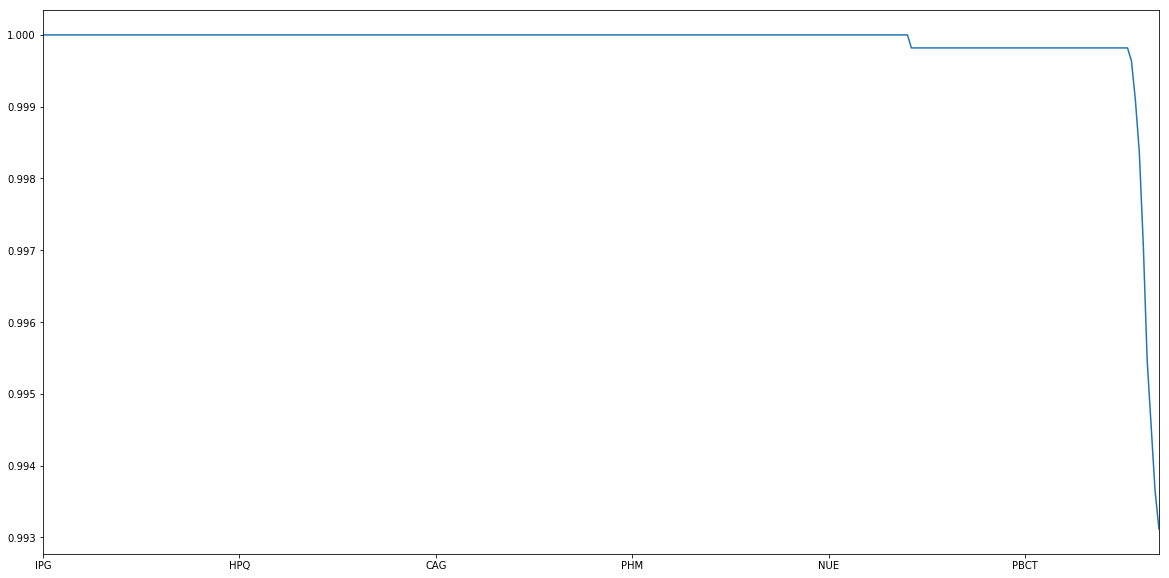

In [23]:
good_ratios = 1.0 - (filtered_data_df['Close'].isnull().sum()/ filtered_data_df['Close'].shape[0])
good_ratios.sort_values(ascending=False).plot()

## Now, let's filter at the sample level

In [24]:
import predictor.feature_extraction as fe

train_time = -1 # In real time days
base_days = 7 # In market days
step_days = 30 # market days
ahead_days = 1 # market days
today = data_df.index[-1] # Real date

tic = time()
x, y = fe.generate_train_intervals(data_df, 
                                   train_time, 
                                   base_days, 
                                   step_days, 
                                   ahead_days, 
                                   today, 
                                   fe.feature_close_one_to_one)
toc = time()
print('Elapsed time: %i seconds.' % (toc-tic))

Elapsed time: 53 seconds.


In [25]:
x.shape

(73478, 7)

In [26]:
y.shape

(73478, 1)

In [27]:
x_y_df = pd.concat([x, y], axis=1)

In [28]:
x_y_df.shape

(73478, 8)

In [29]:
x_y_df.head()

,,0,1,2,3,4,5,6,target
2014-11-18,TSS,102.85,103.03,103.46,103.81,103.79,103.43,104.37,104.45
2011-06-03,MJN,48.19,48.51,48.68,48.79,48.92,48.25,48.78,49.35
2001-07-09,GOOGL,7.15,7.32,7.35,7.50,7.68,7.83,7.83,7.65
2014-01-21,STI,31.22,31.59,31.43,30.77,30.38,30.05,30.14,30.56
2008-03-17,ZBH,75.63,76.76,75.53,78.55,78.95,78.84,78.06,77.16


In [31]:
x_y_df.isnull().sum(axis=1).sum()

312

In [41]:
import utils.preprocessing as pp

In [44]:
x_y_dropped_df = pp.drop_irrelevant_samples(x_y_df, -1)

In [45]:
x_y_dropped_df.isnull().sum(axis=1).sum()

0

In [46]:
print(x_y_dropped_df.shape)
x_y_dropped_df.head()

(73308, 8)


0      1      2      3      4      5      6  target
1993-01-29 AAL   18.75  19.12  20.25  20.50  20.12  19.62  19.75   19.75
           ABBV   2.12   2.19   2.15   2.14   2.12   2.04   2.02    2.03
           ABC    2.62   2.62   2.56   2.62   2.69   2.62   2.44    2.44
           ADI   21.94  22.38  22.31  22.69  23.19  24.00  23.25   22.75
           ADP   15.25  15.25  15.06  15.56  15.69  15.81  15.75   15.69